# Python notebook for finding peaks in csv file data.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
NOTE: Looks for data files in the image_stacks directory.<br>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [1]:
from __future__ import print_function
import csv
import datetime
import glob
import os
from ipywidgets import interact, Layout
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy import signal
from scipy.optimize import curve_fit

# global variables
if os.name == "nt":
    FILE_SEP = "\\"
else:
    FILE_SEP = "/"


#### Create a new time-stamped results directory.

In [2]:
# create time-stamped results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
resultsdir = "../results/" + resultsdir
os.mkdir(resultsdir)


#### Select a data file and one or more regions.
NOTE: Assumes file format in which the first column contains time values in seconds and subsequent region columns contain intensity data.<br>
Select multiple regions using &lt;command-click&gt;.

In [3]:
%matplotlib widget

# global variables
data_file = ""  # the selected data file
data_cols = []  # the data columns

# create data files widget
data_files = sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../image_stacks/*.csv", recursive=False)], key=str.casefold)
data_files_widget = widgets.Select(options=data_files, description='Data file', 
                            disabled=False, layout={'width':'400px'}, style={'description_width':'100px'})
# create region columns widget
columns_widget = widgets.SelectMultiple(options=[], description='Region cols',
                            disabled=False, layout={'width':'150px', 'height':'120px'}, style={'description_width':'100px'})

# create status widget
status_widget = widgets.HTML(value=' ', description=' ')

# update the columns based on the data file selection
def update_columns(*args):
  if data_files_widget.value == None:
    return
  with open("../image_stacks/" + data_files_widget.value, 'r', encoding='utf-8-sig') as f: 
    cols = (np.genfromtxt(f, dtype=float, delimiter=',')).shape[1]
  columns_widget.options = range(1,cols)
  columns_widget.value = [1]

# widget change callbacks
data_files_widget.observe(update_columns, 'value')

# display and respond to the widgets
update_columns()
def f(w1, w2, w3):
  global data_file, data_cols, zones
  data_file = data_files_widget.value
  data_cols = columns_widget.value
  if not data_file:
    status_widget.value = "No data file selected."
  else:
    if not data_cols:
      status_widget.value = "No region(s) selected."
    else:
      status_widget.value = "Selection OK."

display(widgets.interactive(f, w1=data_files_widget, w2=columns_widget, w3=status_widget))


interactive(children=(Select(description='Data file', layout=Layout(width='400px'), options=('gCAMP Template-E…

#### Plot data.

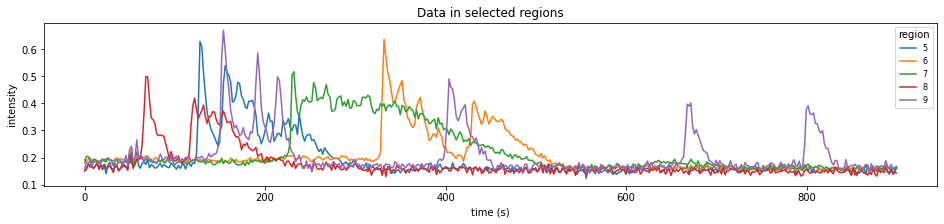

In [24]:
%matplotlib inline

#global variables
cols = np.array(data_cols)

with open("../image_stacks/" + data_file, 'r', encoding='utf-8-sig') as f: 
  A0 = np.transpose(np.genfromtxt(f, dtype=float, delimiter=','))
tmin = np.min(A0[0])            # start time
tmax = np.max(A0[0])            # finish time

dmin = np.amin(A0[cols])
dmax = np.amax(A0[cols])

plt.close('all')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
ax.set_title("Data in selected regions")
ax.set(ylabel="intensity")
ax.set(xlabel="time (s)")
ax.plot(A0[0],np.transpose(A0[cols]))
if len(data_cols) < 11:
  ax.legend(cols, title='region', fontsize=8)
plt.show()


#### Set stimulation time zone ranges.

In [5]:
%matplotlib widget

# global variables
zones = [] # stimulation time zones 

# create number of zones widget
num_zones_widget = widgets.Dropdown(
    options=['1','2','3','4','5','6'],
    value='1',
    description='Number of zones:',
    disabled=False,
    layout={'width':'270px'}, style={'description_width':'200px'}
)

# create zone widget(s)
zone_widgets = []
for i in range(len(num_zones_widget.options)):
    zone_widgets.append(widgets.IntRangeSlider(
        value=(tmin,tmin), min=tmin, max=tmax, step=10,
        description="Stimulation zone " + str(i+1) +' (s)',
        disabled=True, continuous_update=False, orientation='horizontal',
        readout=True, readout_format='d',
        layout={'width':'900px'}, style={'description_width':'200px'}))

# update the zone widgets based on the number of zones value
def update_zone_widgets(*args):
    for i,z in enumerate(zone_widgets):
        nz = int(num_zones_widget.value) # the desired number of zones
        dt = int(tmax-tmin) / nz
        if(i+1 <= nz):
            z.value = (tmin + (i*dt), tmin + (i+1)*dt)
            z.disabled = False
        else:
            z.value = (tmin,tmin)
            z.disabled = True

# widget change callbacks
num_zones_widget.observe(update_zone_widgets, 'value')

# display and respond to the widgets
update_zone_widgets()
def f(w1, w2, w3, w4, w5, w6, w7):
  global zones
  zones = [w.value for w in zone_widgets if not w.disabled]
display(widgets.interactive(f,
                           w1=num_zones_widget,
                           w2=zone_widgets[0],
                           w3=zone_widgets[1],
                           w4=zone_widgets[2],
                           w5=zone_widgets[3],
                           w6=zone_widgets[4],
                           w7=zone_widgets[5]))


interactive(children=(Dropdown(description='Number of zones:', layout=Layout(width='270px'), options=('1', '2'…

#### Plot data and stimulation time zones.
- Stimulation zones are marked with a white background color

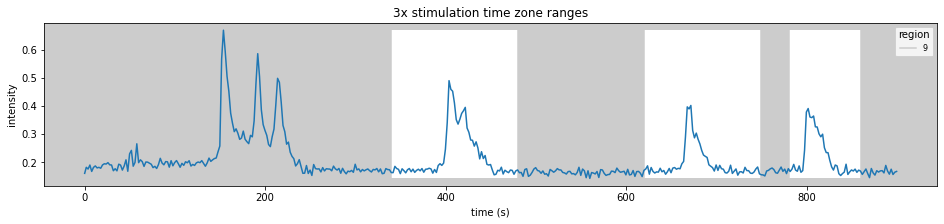

In [20]:
%matplotlib inline

#global variables
zn = np.array(zones)

plt.close('all')
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13,3), constrained_layout=True)
ax.set_title(str(len(zn)) + "x stimulation time zone ranges")
ax.set(ylabel="intensity")
ax.set(xlabel="time (s)")

# grey out plot areas not in any zone
ax.set_facecolor('0.8')
for z in zn:
  ax.fill((z[0],z[1],z[1],z[0]),(dmin,dmin,dmax,dmax),'1.0')
ax.plot([zn[:,0],zn[:,0]],[dmin,dmax],color='0.8') # grey vertical lines in case zones overlap
ax.plot([zn[:,1],zn[:,1]],[dmin,dmax],color='0.8') #    

ax.plot(A0[0],np.transpose(A0[cols]))
#ax.plot([zn[:,0],zn[:,0]],[dmin,dmax],color='0.8')
if len(data_cols) < 11:
  ax.legend(cols, title='region', fontsize=8)
plt.show()


#### Peak counting and latency calculation settings.

In [8]:
%matplotlib widget

# global variables
pk_options = (0,0)
calc_latency = False
slope_type = 0
num_std = 0
baseline = (0,0)

# create sensitivity widget
sensitivity_widget = widgets.Dropdown(
    options=[('low',(0.06,4)),('low-medium',(0.05,6)),('medium',(0.04,7)),('high-medium',(0.03,8)),('high',(0.02,9))],
    value=(0.04,7),
    description='Peak counting sensitivity:',
    disabled=False,
    layout={'width':'350px'}, style={'description_width':'180px'}
)
# create type of slope calculation widget
slope_widget = widgets.Dropdown(
    options = [('simple difference',(1)),('three-neighbour',(2)),('polynomial fit',(3)),('gaussian fit',(4))],
    value = 1,
    description='Slope calculation method:',
    disabled = False,
    layout={'width':'350px'}, style = {'description_width':'180px'}
)
# create number of standard deviations widget
std_widget = widgets.Dropdown(
    options = [('1',(1)),('2',(2)),('3',(3)),('4',(4)),('5',(5)),('6',(6)),('7',(7))],
    value = 2,
    description = 'Threshold standard deviations:',
    disabled = False,
    layout={'width':'260px'}, style = {'description_width':'200px'}
)
# create baseleine zone widget
baseline_widget = widgets.IntRangeSlider(
    value=(tmin,tmax), min=tmin, max=tmax, step=10,
    description="Baseline unstimulated time"+' (s)',
    disabled=False, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='d',
    layout={'width':'900px'}, style={'description_width':'200px'}
)
# display and respond to the widgets
def f(w1, w2, w3, w4):
    global pk_options, calc_latency, slope_type, num_std, baseline
    pk_options = sensitivity_widget.value
    slope_type = slope_widget.value
    num_std = std_widget.value
    baseline = baseline_widget.value
    if (baseline[1]-baseline[0]) < 10: # enforce minimum length baseline
        baseline = (baseline[0], baseline[0] + 10)
        baseline_widget.value = baseline
display(widgets.interactive(f, w1=sensitivity_widget, w2=slope_widget, w3 = baseline_widget, w4 = std_widget))


interactive(children=(Dropdown(description='Peak counting sensitivity:', index=2, layout=Layout(width='350px')…

#### Plot peaks and calculate latencies by region.
- Peak points are marked with black color
- unstimulated time baseline and threshold is marked with light grey color
- latency response start points are marked with red color

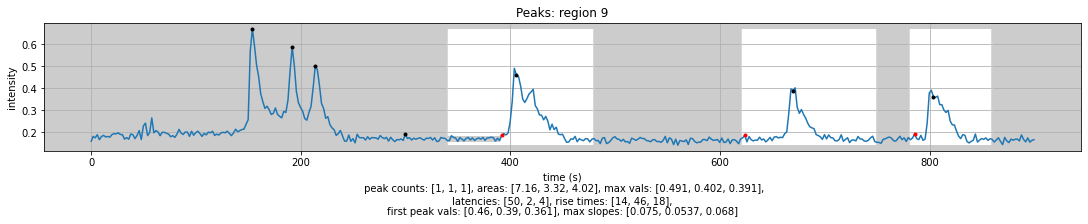

In [23]:
%matplotlib inline

def poly(x, a, b , c):
    return a * x + b * x**2 + c
def gauss(x, a, x0, sigma, y0):
    return y0 + (a * np.exp(-(x - x0)**2/(2*sigma**2)))

#global variables
zn = np.array(zones)

X0 = A0[0]
sr = 6.0                            # desired sample rate
csr = (len(X0) - 1) / (tmax-tmin)   # current sample rate
p = int((sr / csr) * len(X0))       # new number of points
dmin = np.amin(A0[cols])
dmax = np.amax(A0[cols])

##### adjustment for different data sources #####
if (csr < 1.0):
  filter_factor = 0.05
  prominence_factor = 3.0
else:
  filter_factor = 1.0
  prominence_factor = 1.0
#################################################

# write out the CSV file name
f = open(resultsdir + '/' + "csv_file.txt", "w")
f.write(data_file + '\n')
f.close()

# delete any previous results
for f in glob.glob(resultsdir + "/peaks_*.csv"): os.remove(f)  
for f in glob.glob(resultsdir + "/peaks_*.pdf"): os.remove(f)
plt.close('all')

cts = []         # peak counts            per zone, per region
idx_fpks = []    # first peak indices          "        "
idx_lsts = []    # latency start indices       "        "
latencies = []   # latencies                   "        "
rise_times = []  # rise times                  "        "
max_slopes = []  # maximum slopes              "        "
zone_areas = []  # area under curve            "        "
max_vals = []    # maximum values              "        "

for col in cols: # for each region...
  Y0 = A0[col]
  Y1 = (Y0-dmin) / (dmax-dmin) # data axis, normalized to range(0, 1.0)

  # resample
  f = interp1d(X0, Y1, kind='cubic')                    # define the resampling function
  X = np.linspace(tmin, tmax, p+1, endpoint=True)       # define the new time steps
  Y = f(X)                                              # resample the original signal

  # apply high-pass filter to eliminate the stimulation "bump" in the data
  sos = signal.butter(3, 0.1*filter_factor, btype='highpass', fs=sr, output='sos')
  Yf = signal.sosfiltfilt(sos, Y) # zero phase shift filter

  # apply low-pass filter to smooth out higher frequencies in the data
  sos = signal.butter(pk_options[1], 2.0*filter_factor, btype='lowpass', fs=sr, output='sos')
  Yf = signal.sosfiltfilt(sos, Yf) # zero phase shift filter

  # find all the peaks
  pks,_ = signal.find_peaks(Yf,prominence=pk_options[0]*prominence_factor)  # find indices of peaks in the resampled, filtered data
  pidx = np.around((X0.shape[0]-1)*pks/p).astype(int) # convert to indices in the original data
  pts = [A0[0][pidx], A0[col][pidx]]                  # save the peaks as points in the original data
  c = []   # peak counts per zone
  for z in zn: # get peak counts in each zone
    idx = pidx[(pidx >= np.where(A0[0] > z[0])[0][0]) & (pidx <= np.where(A0[0] < z[1])[0][-1])]
    c.append(len(idx))
  cts.append(c)

  # initialise the region plot
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), constrained_layout=True)
  ax.grid(b=True)
  ax.set_title("Peaks: region " + str(col))
  ax.set(ylabel="intensity")

  # grey out plot areas not in any zone
  ax.set_facecolor('0.8')
  for z in zn:
    ax.fill((z[0],z[1],z[1],z[0]),(dmin,dmin,dmax,dmax),'1.0')
  ax.plot([zn[:,0],zn[:,0]],[dmin,dmax],color='0.8') # grey vertical lines in case zones overlap
  ax.plot([zn[:,1],zn[:,1]],[dmin,dmax],color='0.8') #    

  # plot baseline region marking
  # analyse "noise" in the baseline region (for latency calculation)
  signal_avg = np.mean(A0[col][np.logical_and(A0[0] > baseline[0], A0[0] < baseline[1])])    # dc component of noisy signal
  noise = A0[col][np.logical_and(A0[0] > baseline[0], A0[0] < baseline[1])] - signal_avg     # ac     "        "
  thresh = signal_avg + num_std * np.std(noise)                                              # latency threshold value
  mthresh = signal_avg - num_std * np.std(noise)                                             # mirror threshold value around signal_avg 
  ax.fill((baseline[0],baseline[1],baseline[1],baseline[0]),(mthresh, mthresh, thresh, thresh),'0.8')  # mark threshold region on plot 
    
  # plot data and peaks
  ax.plot(A0[0],A0[col])                    # plot data for this region
  ax.plot(A0[0,pidx],A0[col,pidx],'k.')     # plot the peak locations
  #ax.plot(X,Yf)
 
  # find first peak, latency start point, latency, max slope and area under curve for every zone in this region
  idx_fpk = []  # first peak     indices for this region
  idx_lst = []  # latency start      "        "
  lats = []  #    latencies       per zone, for this region
  riss = []  #    rise times          "        "
  slps = []  #  maximum slopes        "        "
  zars = []  # area under curve       "        "
  maxs = []  # maximum values         "        "
  for z in zn:     # for each zone...
    zidx = np.where(np.logical_and(A0[0] > z[0], A0[0] < z[1]))[0]                                  # all indices within zone
    pzidx = pidx[(pidx >= np.where(A0[0] > z[0])[0][0]) & (pidx <= np.where(A0[0] < z[1])[0][-1])]  # peak  "        "
    idxf = -1      # first peak index for this zone     
    idxl = -1      # latency start index for this zone 
    if len(pzidx) > 0:                      # any peaks in this zone?
      idxf = pzidx[0]                       # save the first peak index
      for i in zidx:                        # find latency start point in this zone
        if A0[col,i] >= thresh:             # above the threshold?
          ax.plot(A0[0,i],A0[col,i],'r.')   # plot the latency start location
          idxl = i                          # save 
          break
    idx_fpk.append(idxf)                    # save first peak
    idx_lst.append(idxl)                    #   "  latency start   

    lat = 0
    ris = 0
    slp = 0
    if (idxf != -1) and (idxl != -1):
      lat = A0[0,idxl] - A0[0,zidx[0]] # save latency time
      ris = A0[0,idxf] - A0[0,idxl]    # save rise time
      x_vals = A0[0,idxl:idxf+1]
      y_vals = A0[col,idxl:idxf+1]
      if slope_type == 1:      # Simple difference calculations
        for i in range(len(x_vals)-1):
          sl = (y_vals[i+1] - y_vals[i]) / (x_vals[i+1] - x_vals[i])
          if sl > slp:
            slp = sl
      if slope_type == 2:      # Three neighbor numerical calculations
        if len(x_vals) > 5:
          for j in range(3, len(x_vals) - 3):
            sls = []
            for k in range(1,4):
              y1 = y_vals[j - k]
              y2 = y_vals[j + k]
              x1 = x_vals[j - k]
              x2 = x_vals[j + k]
              sls.append((y2 - y1) / (x2 - x1))
            sl = np.mean(sls)
            if sl > slp:
              slp = sl
      if slope_type == 3:       # Polynomial fit calculations
        if len(x_vals) > 3:
          popt, pcov = curve_fit(poly, x_vals, y_vals)
          fitted_y_vals = poly(x_vals, *popt)
          ax.plot(x_vals,fitted_y_vals,'r')
          if len(fitted_y_vals) > 3:
            for i in range (1, len(fitted_y_vals)):
              sl = (fitted_y_vals[i] - fitted_y_vals[i - 1]) / (x_vals[i] - x_vals[i - 1])
              if sl > slp:
                slp = sl
      if slope_type == 4:     # Gaussian fit calculations
        x_vals = A0[0,idxl:idxf+1+len(x_vals)]     # extend selection of values to be symetrical aroung the peak
        y_vals = A0[col,idxl:idxf+1+len(y_vals)]   #
        if len(x_vals) > 6:
          mean = sum(x_vals * y_vals) / len(x_vals)
          sigma = sum(y_vals * (x_vals - mean)**2) / len(x_vals)
          y0 = thresh
          popt, pcov = curve_fit(gauss, x_vals, y_vals, p0=[max(y_vals),mean,sigma,y0],maxfev = 5000)
          fitted_y_vals = gauss(x_vals, *popt)
          ax.plot(x_vals,fitted_y_vals,'r')
          peak_index = np.where(fitted_y_vals == np.max(fitted_y_vals))      # Find where peak of gaussian curve
          for i in range(1, int(peak_index[0])):                             # Find slopes up to peak of gaussian curve
            sl = (fitted_y_vals[i] - fitted_y_vals[i - 1]) / (x_vals[i] - x_vals[i - 1])
            if sl > slp:
              slp = sl

    lats.append(lat)
    riss.append(ris)
    slps.append(slp)        
    zars.append(np.trapz(A0[col,zidx] - signal_avg, A0[0,zidx]))   # calculate and save area under curve
    maxs.append(np.amax(A0[col,zidx]))

  idx_fpks.append(idx_fpk) # save the first peaks across all regions
  idx_lsts.append(idx_lst) #        latency starts
  latencies.append(lats)   # save    latencies     across all regions
  rise_times.append(riss)  #  "     rise times         "
  max_slopes.append(slps)  #  "     maximum slopes     "
  zone_areas.append(zars)  #  "    area under curve    "
  max_vals.append(maxs)    #  "     maximum values     "

  # finalise and save the region plot    
  xlab = "time (s)\n peak counts: " + str(c)
  xlab += (", areas: ["+', '.join(['%.3g']*len(zars))+"]") % tuple(zars)
  xlab += (", max vals: ["+', '.join(['%.3g']*len(maxs))+"]") % tuple(maxs)
  xlab += (",\nlatencies: ["+', '.join(['%.3g']*len(lats))+"]") % tuple(lats)
  xlab += (", rise times: ["+', '.join(['%.3g']*len(riss))+"]") % tuple(riss)
  xlab += (",\nfirst peak vals: ["+', '.join(['%.3g']*len(idx_fpk))+"]") % tuple([A0[col,x] if x!=-1 else 0 for x in idx_fpk])
  xlab += (", max slopes: ["+', '.join(['%.3g']*len(slps))+"]") % tuple(slps)
  ax.set(xlabel=xlab)
  fig.savefig(resultsdir + "/peaks_region_" + str(col) + ".pdf") # save figure as pdf
  plt.show()
  plt.close() # frees up memory

  # save peak points to CSV file
  with open (resultsdir + "/all_peaks_region_" + str(col) + ".csv", 'w') as file:
    writer = csv.writer(file)
    for pk in pidx:
      writer.writerow((A0[0,pk],A0[col,pk]))

# save peak count and optional latency summary to CSV file
with open (resultsdir + "/peaks_latencies_summary.csv", 'w') as file:
  writer = csv.writer(file)
  writer.writerow(("zone number", "peak counts", "areas", "maximum values", "latencies", "rise times", "first peak values", "maximum slopes"))
  for i in range(len(cols)):
    r = ([cols[i]], cts[i], [A0[cols[i],x] if x!=-1 else 0 for x in idx_fpks[i]], zone_areas[i], max_vals[i], latencies[i], rise_times[i], max_slopes[i])
    writer.writerow('{:.3g}'.format(x) for x in tuple(np.concatenate(r))) 
    

#### Plot peak count summary.

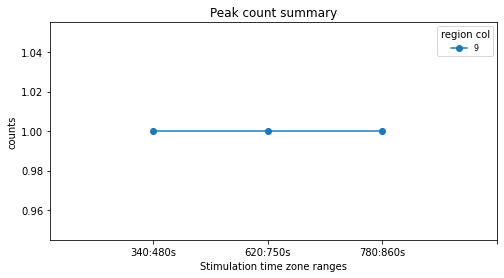

In [16]:
# peak count summary
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4), constrained_layout=False)
ax.set_title("Peak count summary")
ax.set(xlabel="Stimulation time zone ranges")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
x_fmt = mpl.ticker.IndexFormatter([str(z[0])+':'+str(z[1])+'s' for z in zones])
ax.xaxis.set_major_formatter(x_fmt)
ax.set(ylabel="counts")
ax.plot(np.transpose(cts), marker='o')
ax.legend(cols, title='region col', fontsize=8)
plt.xlim(-0.9,len(zones))
plt.show()
plt.close()

